# Feature variation by substitution ($\nu_{\phi}$)

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographical_density']
N_COMPONENTS = 3

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from progressbar import ProgressBar

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope
engine = init_db()

## 2 Variation of features upon substitution

First build our data.

In [3]:
model = Model(Time.discrete, Source.majority, Past.last_bin, Durl.all)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, destination = substitution.features(feature)
            source_rel, destination_rel = substitution.features(feature,
                                                                sentence_relative='median')
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'source': source,
                         'source_rel': source_rel,
                         'destination': destination,
                         'destination_rel': destination_rel,
                         'h0': substitution.feature_average(feature),
                         'h0_rel': substitution.feature_average(feature,
                                                                sentence_relative='median'),
                         'h0n': substitution.feature_average(feature,
                                                             source_synonyms=True),
                         'h0n_rel': substitution.feature_average(feature,
                                                                 source_synonyms=True,
                                                                 sentence_relative='median')})

original_variations = pd.DataFrame(data)
del data

Got 9071 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all)


100% (9071 of 9071) |######################| Elapsed Time: 0:02:33 Time: 0:02:33


Compute cluster averages (so as not to overestimate confidence intervals) and crop data so that we have acceptable CIs.

In [4]:
variations = original_variations\
    .groupby(['destination_id', 'occurrence', 'feature'], as_index=False).mean()\
    .groupby(['cluster_id', 'feature'], as_index=False)\
    ['source', 'source_rel', 'destination', 'destination_rel', 'feature',
     'h0', 'h0_rel', 'h0n', 'h0n_rel'].mean()
variations['variation'] = variations['destination'] - variations['source']

# HARDCODED: drop values where source AoA is above 15.
# This crops the graphs to acceptable CIs.
variations.loc[(variations.feature == 'aoa') & (variations.source > 15),
               ['source', 'source_rel', 'destination', 'destination_rel',
                'h0', 'h0_rel', 'h0n', 'h0n_rel']] = np.nan

### 2.1 What we plot about features

For a feature $\phi$, plot:

* $\nu_{\phi}$, the variation of the feature upon substitution
* $\nu_{\phi}^0$ (which is the average feature value), i.e. what happens under $\mathcal{H}_0$
* $\nu_{\phi}^{00}$ (which is the average feature value for synonyms of the source word), i.e. what happens under $\mathcal{H}_{00}$
* $y = x$, i.e. what happens if there is no substitution

We also plot these values relative to the sentence average, i.e.:

* $\nu_{\phi, r}$, the variation, upon substitution, of the changing word's feature compared to the sentence average, i.e. $f($destination$) - f($destination sentence$) - (f($source$) - f($source sentence$))$
* $\nu_{\phi, r}^0$ (which is the average feature value minus the sentence average), i.e. what happens under $\mathcal{H}_0$
* $\nu_{\phi, r}^{00}$ (which is the average feature value for synonyms of the source word minus the sentence average), i.e. what happens under $\mathcal{H}_{00}$
* $y = x$, i.e. what happens if there is no substitution

Those values are plotted below in two groups each time, first the absolute feature values, then the relative-to-sentence features.

In [5]:
def plot_variation(**kwargs):
    data = kwargs.pop('data')
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    rel = '_rel' if relative else ''
    x = data['source' + rel]
    y = data['destination' + rel]
    h0 = data['h0' + rel]
    h0n = data['h0n' + rel]
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    h0s = np.zeros(bin_count)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        h0s[i] = h0[x_bins == i].mean()
        h0ns[i] = h0n[x_bins == i].mean()
        values[i] = y[x_bins == i].mean()
        cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    nuphi = r'\nu_{\phi' + (',r' if relative else '') + '}'
    plt.plot(middles, values, '-', lw=2, color=color, label='${}$'.format(nuphi))
    plt.fill_between(middles, values - cis, values + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, h0s, '--', color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(nuphi))
    plt.plot(middles, h0ns, linestyle='-.', color=sb.desaturate(color, 0.2),
             label='${}^{{00}}$'.format(nuphi))
    plt.plot(middles, middles, linestyle='dotted', color=sb.desaturate(color, 0.2),
             label='$y = x$')
    lmin, lmax = middles[0], middles[-1]
    h0min, h0max = min(h0s.min(), h0ns.min()), max(h0s.max(), h0ns.max())
    # Rescale limits if we're touching H0 or H00.
    if h0min < lmin:
        lmin = h0min - (lmax - h0min) / 10
    elif h0max > lmax:
        lmax = h0max + (h0max - lmin) / 10
    plt.xlim(lmin, lmax)
    plt.ylim(lmin, lmax)

In [6]:
def plot_bias(ax, data, color, ci=True, relative=False):
    feature = data.iloc[0].feature
    rel = '_rel' if relative else ''
    x = data['source' + rel]
    y = data['destination' + rel]
    h0 = data['h0' + rel]
    h0n = data['h0n' + rel]
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    
    # Compute bin values.
    h0s = np.zeros(bin_count)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        h0s[i] = h0[x_bins == i].mean()
        h0ns[i] = h0n[x_bins == i].mean()
        values[i] = y[x_bins == i].mean()
        cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    scale = abs(h0s.mean())
    ax.plot(np.linspace(0, 1, bin_count), (values - h0ns) / scale, '-', lw=2, color=color,
            label=Substitution._transformed_feature(feature).__doc__)
    if ci:
        ax.fill_between(np.linspace(0, 1, bin_count),
                        (values - h0ns - cis) / scale, (values - h0ns + cis) / scale,
                        color=sb.desaturate(color, 0.2), alpha=0.2)        

### 2.2 All feature variations

For each feature $\phi$, we plot the variation upon substitution as explained above

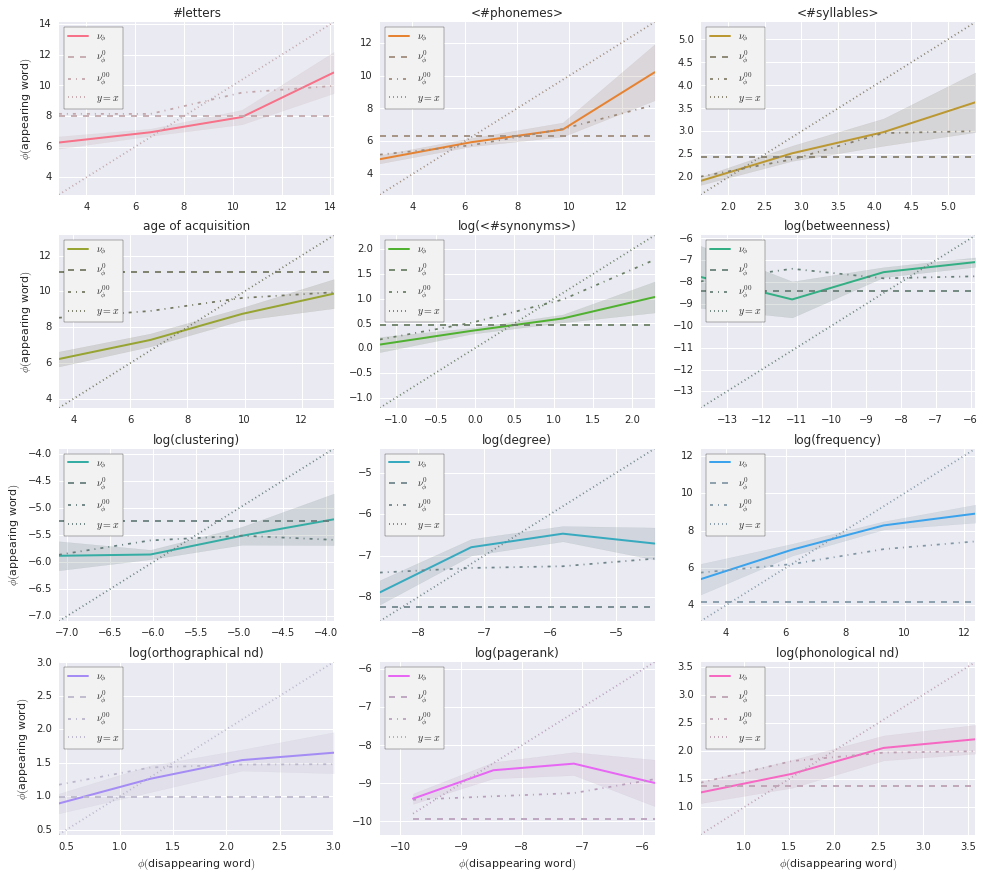

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=variations, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_variation)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($disappearing word$)$')
g.set_ylabels(r'$\phi($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_variations-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative features.

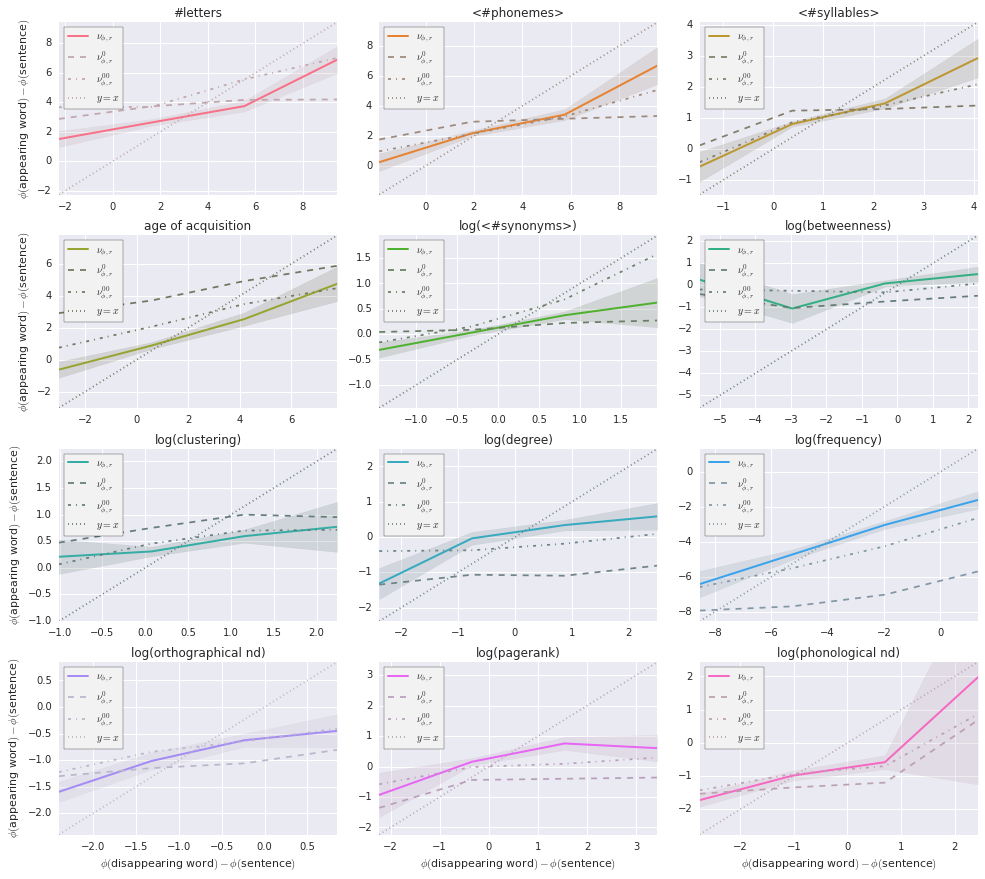

In [8]:
g = sb.FacetGrid(data=variations, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_variation, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($disappearing word$) - \phi($sentence$)$')
g.set_ylabels(r'$\phi($appearing word$) - \phi($sentence$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_variations-relative'),
                  bbox_inches='tight', dpi=300)

Then plot $\nu_{\phi} - \nu_{\phi}^{00}$ for each feature (i.e. the measured bias) to see how they compare

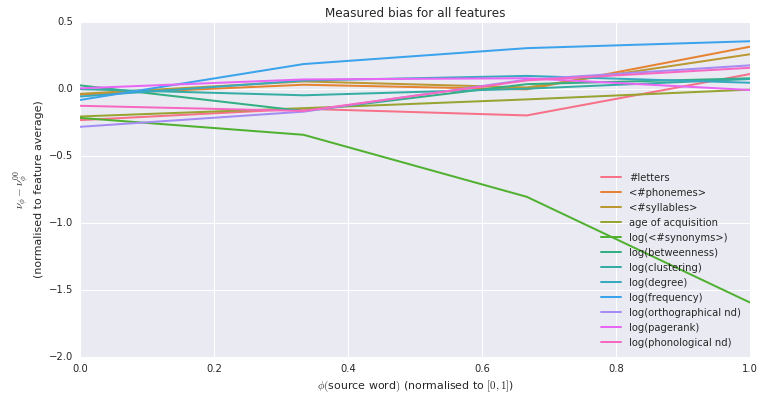

In [9]:
palette = sb.color_palette('husl', len(Substitution.__features__))
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(ordered_features):
    plot_bias(ax, variations[variations['feature'] == feature].dropna(),
              color=palette[j], ci=False)
ax.legend(loc='lower right')
ax.set_title('Measured bias for all features')
ax.set_xlabel(r'$\phi($source word$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi} - \nu_{\phi}^{00}$' + '\n(normalised to feature average)')
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-feature_bias-absolute'),
                bbox_inches='tight', dpi=300)

Now with sentence-relative features.

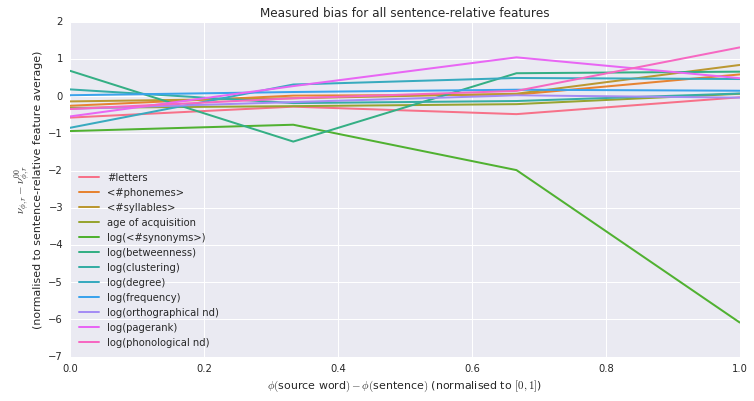

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(ordered_features):
    plot_bias(ax, variations[variations['feature'] == feature].dropna(),
              color=palette[j], ci=False, relative=True)
ax.legend(loc='lower left')
ax.set_title('Measured bias for all sentence-relative features')
ax.set_xlabel(r'$\phi($source word$) - \phi($sentence$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi,r} - \nu_{\phi,r}^{00}$' +
              '\n(normalised to sentence-relative feature average)')
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-feature_bias-relative'),
                bbox_inches='tight', dpi=300)

### 2.3 Feature variations, reduced to features we expose in the paper

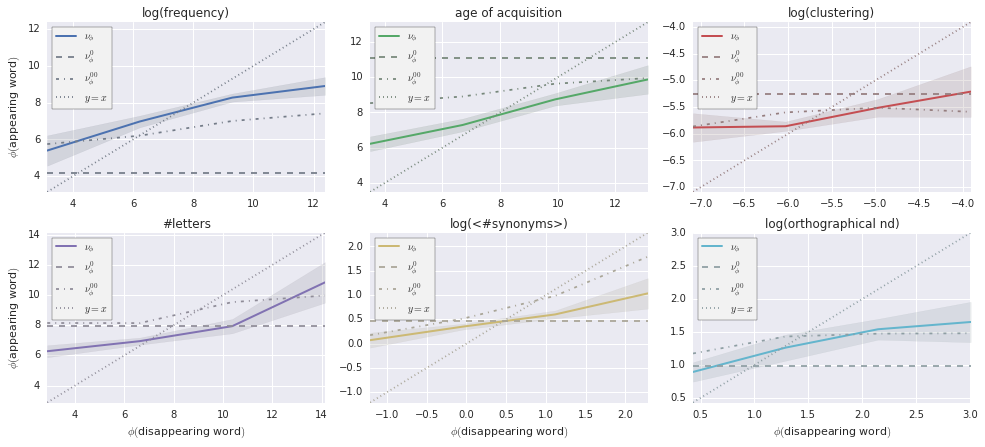

In [11]:
g = sb.FacetGrid(data=variations[variations['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_variation)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($disappearing word$)$')
g.set_ylabels(r'$\phi($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_variations-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative features.

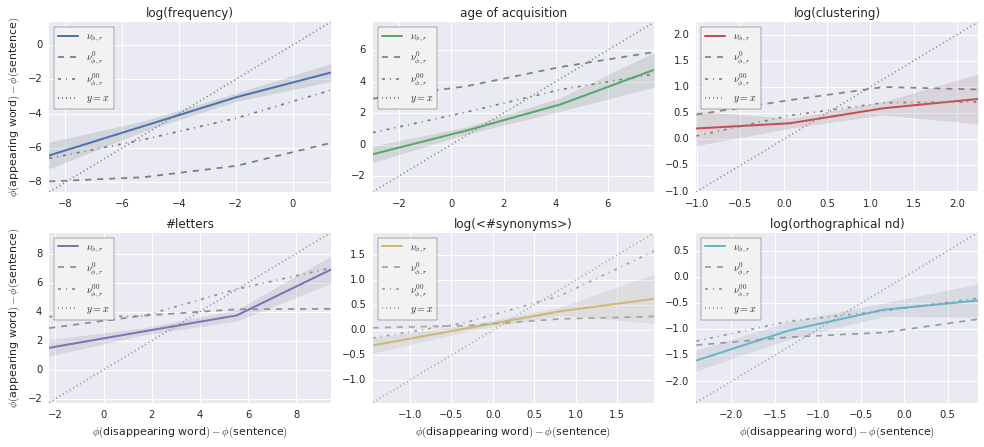

In [12]:
g = sb.FacetGrid(data=variations[variations['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_variation, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($disappearing word$) - \phi($sentence$)$')
g.set_ylabels(r'$\phi($appearing word$) - \phi($sentence$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_variations-relative'),
                  bbox_inches='tight', dpi=300)

Now $\nu_{\phi} - \nu_{\phi}^{00}$

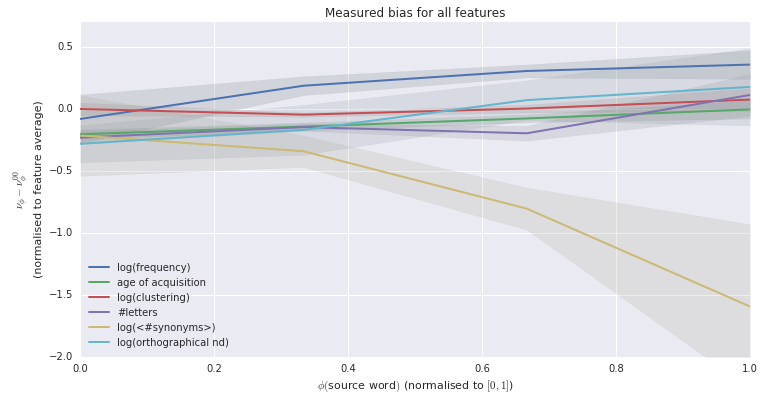

In [13]:
palette = sb.color_palette('deep', len(PAPER_FEATURES))
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(PAPER_FEATURES):
    plot_bias(ax, variations[variations['feature'] == feature].dropna(),
              color=palette[j])
ax.legend(loc='lower left')
ax.set_title('Measured bias for all features')
ax.set_xlabel(r'$\phi($source word$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi} - \nu_{\phi}^{00}$' + '\n(normalised to feature average)')
ax.set_ylim(-2, .7)
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('paper-feature_bias-absolute'),
                bbox_inches='tight', dpi=300)

Now with sentence-relative features.

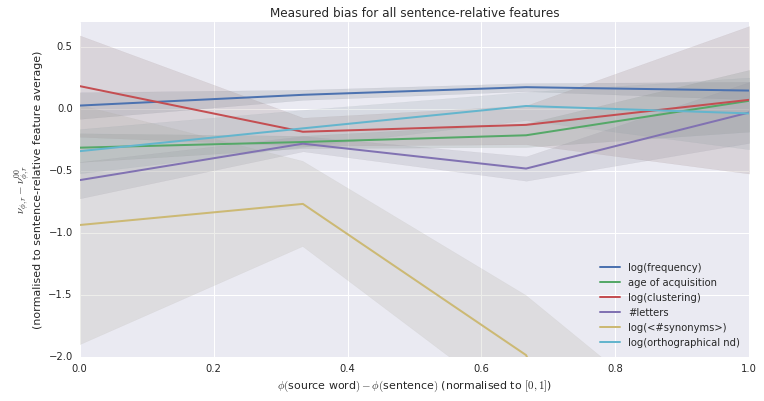

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(PAPER_FEATURES):
    plot_bias(ax, variations[variations['feature'] == feature].dropna(),
              color=palette[j], relative=True)
ax.legend(loc='lower right')
ax.set_title('Measured bias for all sentence-relative features')
ax.set_xlabel(r'$\phi($source word$) - \phi($sentence$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi,r} - \nu_{\phi,r}^{00}$' +
              '\n(normalised to sentence-relative feature average)')
ax.set_ylim(-2, .7)
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('paper-feature_bias-relative'),
                bbox_inches='tight', dpi=300)

## 3 Streamplots

We'd like to see what happens between absolute and relative feature values, i.e. how do their effects interact. Especially, we want to know who wins between cognitive bias, attraction to sentence average, or attraction to global feature average.

To do this we plot the general direction (arrows) and strength (color) of where destination words are given a particular absolute/relative source feature couple. I.e., for a given absolute feature value and relative feature value, if this word were to be substituted, where would it go in this (absolute, relative) space?

The interesting thing in these plots is the attraction front, where all arrows point to and join. We're interested in:
* its slope
* its shape (e.g. several slope regimes?)
* its position w.r.t. $\nu_{\phi}^0$ and $y = 0$ (which is $\left< \phi(sentence) \right>$)

First, here's our plotting function. (Note we set the arrow size to something that turns out to be huge here, but gives normal sizes in the figures saves. There must be some dpi scaling problem with the arrows.)

In [15]:
def plot_stream(**kwargs):
    data = kwargs.pop('data')
    color = kwargs.get('color', 'blue')
    source = data['source']
    source_rel = data['source_rel']
    dest = data['destination']
    dest_rel = data['destination_rel']
    h0 = data['h0']
    
    # Compute binning.
    bin_count = 4
    x_bins, x_margins = pd.cut(source, bin_count, right=False, labels=False, retbins=True)
    x_middles = (x_margins[:-1] + x_margins[1:]) / 2
    y_bins, y_margins = pd.cut(source_rel, bin_count, right=False, labels=False, retbins=True)
    y_middles = (y_margins[:-1] + y_margins[1:]) / 2
    
    # Compute bin values.
    h0s = np.ones(bin_count) * h0.iloc[0]
    u_values = np.zeros((bin_count, bin_count))
    v_values = np.zeros((bin_count, bin_count))
    strength = np.zeros((bin_count, bin_count))
    for x in range(bin_count):
        for y in range(bin_count):
            u_values[y, x] = (dest[(x_bins == x) & (y_bins == y)] -
                              source[(x_bins == x) & (y_bins == y)]).mean()
            v_values[y, x] = (dest_rel[(x_bins == x) & (y_bins == y)] -
                              source_rel[(x_bins == x) & (y_bins == y)]).mean()
            strength[y, x] = np.sqrt((dest[(x_bins == x) & (y_bins == y)] - 
                                      source[(x_bins == x) & (y_bins == y)]) ** 2 +
                                     (dest_rel[(x_bins == x) & (y_bins == y)] - 
                                      source_rel[(x_bins == x) & (y_bins == y)]) ** 2).mean()
    
    # Plot.
    plt.streamplot(x_middles, y_middles, u_values, v_values,
                   arrowsize=4, color=strength, cmap=plt.cm.viridis)
    plt.plot(x_middles, np.zeros(bin_count), linestyle='-',
             color=sb.desaturate(color, 0.2), label=r'$\left< \phi(sentence) \right>$')
    plt.plot(h0s, y_middles, linestyle='--',
             color=sb.desaturate(color, 0.2), label=r'$\nu_{\phi}^0$')
    plt.xlim(x_middles[0], x_middles[-1])
    plt.ylim(y_middles[0], y_middles[-1])

Here are the plots for all features

/home/sl/.virtualenvs/brainscopypaste/lib/python3.5/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


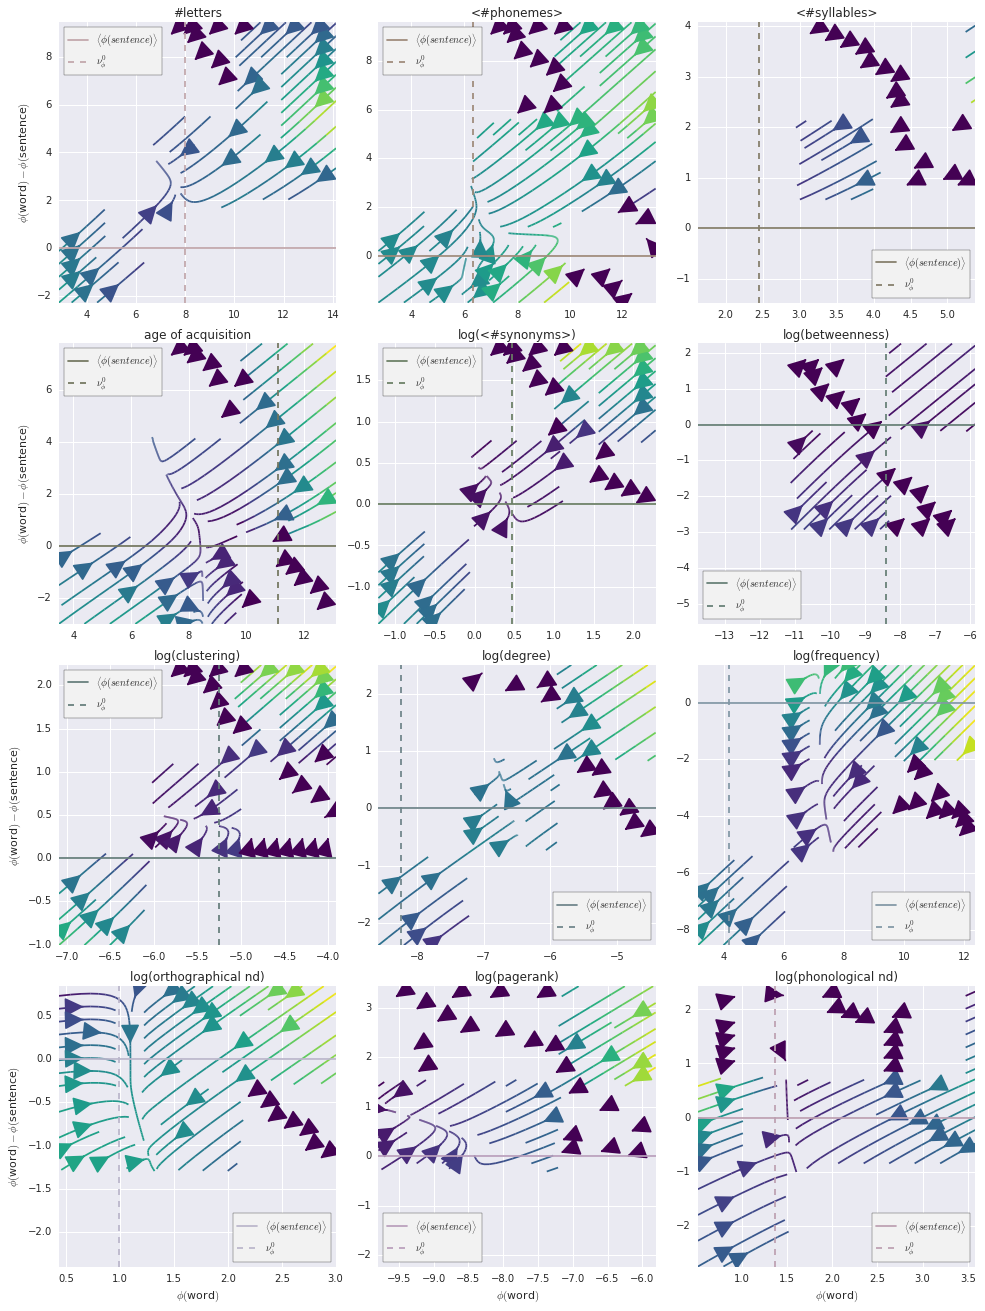

In [16]:
g = sb.FacetGrid(data=variations,
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1, size=4.5,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_stream)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($word$)$')
g.set_ylabels(r'$\phi($word$) - \phi($sentence$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='best')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_streams'),
                  bbox_inches='tight', dpi=300)

And here are the plots for the features we expose in the paper

/home/sl/.virtualenvs/brainscopypaste/lib/python3.5/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


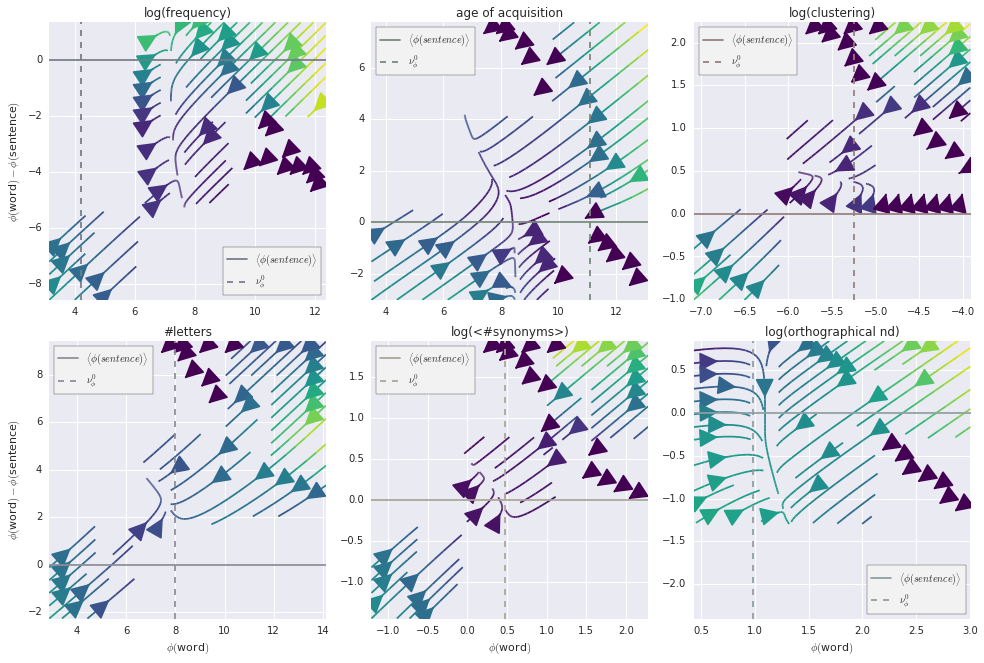

In [17]:
g = sb.FacetGrid(data=variations[variations['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1, size=4.5,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_stream)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($word$)$')
g.set_ylabels(r'$\phi($word$) - \phi($sentence$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='best')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_streams'),
                  bbox_inches='tight', dpi=300)

## 4 PCA'd feature variations

Compute PCA on feature *variations* (note: on variations, not on features directly), and show the evolution of the first three components upon substitution.

**CAVEAT**: the PCA is computed on variations where all features are defined. This greatly reduces the number of words included (and also the number of substitutions -- see below for real values, but you should know it's drastic). This also has an effect on the computation of $\mathcal{H}_0$ and $\mathcal{H}_{00}$, which are computed using words for which all features are defined. This, again, hugely reduces the number of words taken into account.

### 4.1 On all the features

Compute the actual PCA

In [18]:
# Compute the PCA.
pcafeatures = tuple(sorted(Substitution.__features__))
pcavariations = variations.pivot(index='cluster_id', columns='feature', values='variation')
pcavariations = pcavariations.dropna()
pca = PCA(n_components='mle')
pca.fit(pcavariations)

# Show 
print('MLE estimates there are {} components.\n'.format(pca.n_components_))
print('Those explain the following variance:')
print(pca.explained_variance_ratio_)
print()

print("We're plotting variation for the first {} components:".format(N_COMPONENTS))
pd.DataFrame(pca.components_[:N_COMPONENTS],
             columns=pcafeatures,
             index=['Component-{}'.format(i) for i in range(N_COMPONENTS)])

MLE estimates there are 11 components.

Those explain the following variance:
[ 0.51446555  0.17489229  0.09027657  0.07328873  0.03525223  0.03035294
  0.02269237  0.01956296  0.01551358  0.01115776  0.0074942 ]

We're plotting variation for the first 3 components:


,aoa,betweenness,clustering,degree,frequency,letters_count,orthographical_density,pagerank,phonemes_count,phonological_density,syllables_count,synonyms_count
Component-0,-0.494620,0.285122,-0.096906,0.244552,0.220021,-0.428082,0.209175,0.260700,-0.394800,0.281829,-0.161557,0.009108
Component-1,-0.376832,0.347266,-0.102316,0.279024,0.226340,0.457246,-0.161054,0.302833,0.446615,-0.218316,0.153843,-0.018360
Component-2,-0.533138,-0.059417,0.030610,-0.028758,-0.835564,0.075649,0.004000,-0.056422,-0.009812,-0.042775,-0.007291,0.037434


Compute the source and destination component values, along with $\mathcal{H}_0$ and $\mathcal{H}_{00}$, for each component.

In [19]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for component in range(N_COMPONENTS):
            source, destination = substitution.components(component, pca, pcafeatures)
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'component': component,
                         'source': source,
                         'destination': destination,
                         'h0': substitution.component_average(component, pca, pcafeatures),
                         'h0n': substitution.component_average(component, pca, pcafeatures,
                                                               source_synonyms=True)})

original_component_variations = pd.DataFrame(data)
del data

100% (9071 of 9071) |######################| Elapsed Time: 0:02:00 Time: 0:02:00


Compute cluster averages (so as not to overestimate confidence intervals).

In [20]:
component_variations = original_component_variations\
    .groupby(['destination_id', 'occurrence', 'component'], as_index=False).mean()\
    .groupby(['cluster_id', 'component'], as_index=False)\
    ['source', 'destination', 'component', 'h0', 'h0n'].mean()

Plot the actual variations of components (**see the caveat section below**)

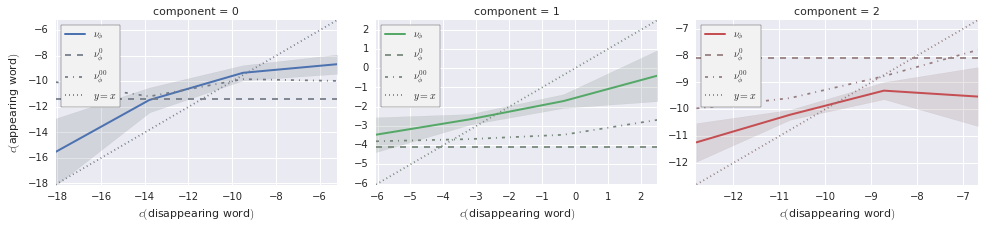

In [21]:
g = sb.FacetGrid(data=component_variations, col='component', col_wrap=3,
                 sharex=False, sharey=False, hue='component',
                 aspect=1.5, size=3)
g.map_dataframe(plot_variation)
g.set_xlabels(r'$c($disappearing word$)$')
g.set_ylabels(r'$c($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-pca_variations-absolute'),
                  bbox_inches='tight', dpi=300)

### 4.2 On the features we expose in the paper

Compute the actual PCA

In [22]:
# Compute the PCA.
pcafeatures = tuple(sorted(PAPER_FEATURES))
pcavariations = variations[variations['feature'].map(lambda f: f in pcafeatures)]\
    .pivot(index='cluster_id', columns='feature', values='variation')
pcavariations = pcavariations.dropna()
pca = PCA(n_components='mle')
pca.fit(pcavariations)

# Show 
print('MLE estimates there are {} components.\n'.format(pca.n_components_))
print('Those explain the following variance:')
print(pca.explained_variance_ratio_)
print()

print("We're plotting variation for the first {} components:".format(N_COMPONENTS))
pd.DataFrame(pca.components_[:N_COMPONENTS],
             columns=pcafeatures,
             index=['Component-{}'.format(i) for i in range(N_COMPONENTS)])

MLE estimates there are 3 components.

Those explain the following variance:
[ 0.55535477  0.1868321   0.15852297]

We're plotting variation for the first 3 components:


,aoa,clustering,frequency,letters_count,orthographical_density,synonyms_count
Component-0,-0.704351,-0.104287,0.273731,-0.584351,0.276561,0.011541
Component-1,0.523824,0.127952,-0.371123,-0.721658,0.225113,-0.006204
Component-2,-0.453066,0.032683,-0.880369,0.130681,0.004302,0.038953


Compute the source and destination component values, along with $\mathcal{H}_0$ and $\mathcal{H}_{00}$, for each component.

In [23]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for component in range(N_COMPONENTS):
            source, destination = substitution.components(component, pca, pcafeatures)
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'component': component,
                         'source': source,
                         'destination': destination,
                         'h0': substitution.component_average(component, pca, pcafeatures),
                         'h0n': substitution.component_average(component, pca, pcafeatures,
                                                               source_synonyms=True)})

original_component_variations = pd.DataFrame(data)
del data

100% (9071 of 9071) |######################| Elapsed Time: 0:01:23 Time: 0:01:23


Compute cluster averages (so as not to overestimate confidence intervals).

In [24]:
component_variations = original_component_variations\
    .groupby(['destination_id', 'occurrence', 'component'], as_index=False).mean()\
    .groupby(['cluster_id', 'component'], as_index=False)\
    ['source', 'destination', 'component', 'h0', 'h0n'].mean()

Plot the actual variations of components

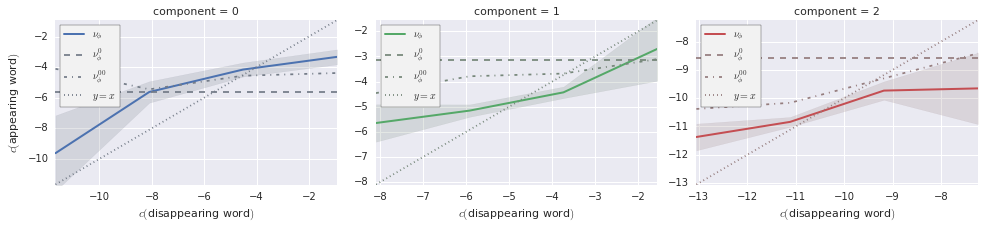

In [25]:
g = sb.FacetGrid(data=component_variations, col='component', col_wrap=3,
                 sharex=False, sharey=False, hue='component',
                 aspect=1.5, size=3)
g.map_dataframe(plot_variation)
g.set_xlabels(r'$c($disappearing word$)$')
g.set_ylabels(r'$c($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-pca_variations-absolute'),
                  bbox_inches='tight', dpi=300)

### 4.3 CAVEAT: reduction of the numbers of words and substitutions

As explained above, this PCA analysis can only use words for which *all* the features are defined (in this case, the features listed in `PAPER_FEATURES`). So note the following:

In [26]:
for feature in PAPER_FEATURES:
    print("Feature '{}' is based on {} words."
          .format(feature, len(Substitution._transformed_feature(feature)())))

# Compute the number of words that have all PAPER_FEATURES defined.
words = set()
for tfeature in [Substitution._transformed_feature(feature) for feature in PAPER_FEATURES]:
    words.update(tfeature())

data = dict((feature, []) for feature in PAPER_FEATURES)
words_list = []
for word in words:
    words_list.append(word)
    for feature in PAPER_FEATURES:
        data[feature].append(Substitution._transformed_feature(feature)(word))
wordsdf = pd.DataFrame(data)
wordsdf['words'] = words_list
del words_list, data

print()
print("Among all the set of words used by these features, only {} are used."
      .format(len(wordsdf.dropna())))

print()
print("Similarly, we mined {} (cluster-unique) substitutions, but the PCA is in fact"
      " computed on {} of them (those where all features are defined)."
      .format(len(set(variations['cluster_id'])), len(pcavariations)))

Feature 'frequency' is based on 33450 words.
Feature 'aoa' is based on 30102 words.
Feature 'clustering' is based on 5739 words.
Feature 'letters_count' is based on 42786 words.
Feature 'synonyms_count' is based on 147306 words.
Feature 'orthographical_density' is based on 27751 words.

Among all the set of words used by these features, only 3322 are used.

Similarly, we mined 1061 (cluster-unique) substitutions, but the PCA is in fact computed on 301 of them (those where all features are defined).


The way $\mathcal{H}_0$ and $\mathcal{H}_{00}$ are computed makes them also affected by this.